In [1]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.scalers import StandardScaler as Scaler
from src.dataloaders import make_dataloaders_from_dataset, make_dataloaders_from_datasets
from src.model import BaseEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, y):
        return torch.sqrt(self.mse(pred, y))

In [19]:
G = nx.readwrite.read_gpickle('data/network.gpickle')

Using subset of only aggregated features

In [20]:
node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
node_attrs = node_attrs[-20:-18] + node_attrs[3:5]
# node_attrs = node_attrs[3:]
pyg_graph = from_networkx(G, group_node_attrs=node_attrs)
pyg_graph.to(device)
print(node_attrs)

['median_income', ' population', 'labor_force_rate', 'housing_sales_num_Total:']


In [21]:
pyg_graph.x = Scaler().fit_transform(pyg_graph.x)
pyg_graph.x.shape

torch.Size([373, 4])

In [22]:
pyg_graph.x[0]

tensor([-0.2044,  0.9894,  0.7052, -0.5941], device='cuda:0')

In [23]:
class LocationScaler(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            # nn.Linear(self.hidden_dim, self.hidden_dim),
            # nn.LeakyReLU(),
            # nn.Dropout(0.5),
            nn.Linear(self.hidden_dim, 1),
            nn.ReLU()
        )

    def forward(self, X):
        out = self.layers(X)
        # out = torch.exp(out)
        return out


class Estimator(BaseEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets)

        self.loc_scaler = LocationScaler(self.g.x.shape[-1])
    
    def forward(self, loc_a):
        loc_indices = torch.as_tensor(self.node_to_idx(loc_a)).to(device)

        loc_emb = self.g.x[loc_indices]
        
        out = self.loc_scaler(loc_emb)
        # out = torch.exp(out)

        # print(self.loc_scaler(loc_b_emb))
        
        return out.reshape(-1)


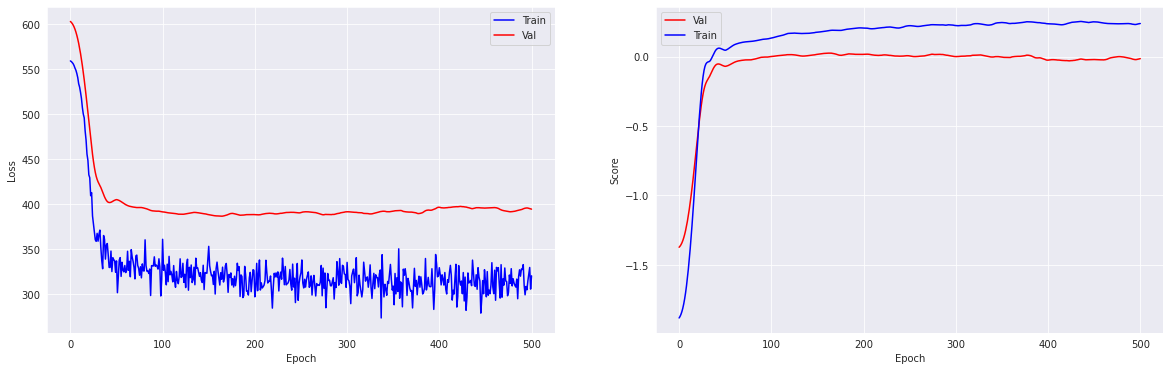

Test loss: 333.2102, test score: -0.2333


In [24]:
import datetime
# loss_fn = nn.HuberLoss(delta=200).to(device)

loss_fn = RMSELoss().to(device)
model = None


ds = torch.load('datasets/2021-01-08.dat')

train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=128)
train_batches = [batch for batch in train_loader]
train_nodes = [n for batch in train_batches for n in batch[0]]
train_targets = torch.cat([batch[1] for batch in train_batches])
    
if model is None:
    model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
else:
    model.set_observations(train_nodes, train_targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=500, plot=True)
test_loss, test_score = test(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

Using all features

In [25]:
node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
node_attrs = node_attrs[3:]
pyg_graph = from_networkx(G, group_node_attrs=node_attrs)
pyg_graph.to(device)
print(node_attrs)

['labor_force_rate', 'housing_sales_num_Total:', 'housing_sales_num_Total:!!Less than $10,000', 'housing_sales_num_Total:!!$10,000 to $14,999', 'housing_sales_num_Total:!!$15,000 to $19,999', 'housing_sales_num_Total:!!$20,000 to $24,999', 'housing_sales_num_Total:!!$25,000 to $29,999', 'housing_sales_num_Total:!!$30,000 to $34,999', 'housing_sales_num_Total:!!$35,000 to $39,999', 'housing_sales_num_Total:!!$40,000 to $49,999', 'housing_sales_num_Total:!!$50,000 to $59,999', 'housing_sales_num_Total:!!$60,000 to $69,999', 'housing_sales_num_Total:!!$70,000 to $79,999', 'housing_sales_num_Total:!!$80,000 to $89,999', 'housing_sales_num_Total:!!$90,000 to $99,999', 'housing_sales_num_Total:!!$100,000 to $124,999', 'housing_sales_num_Total:!!$125,000 to $149,999', 'housing_sales_num_Total:!!$150,000 to $174,999', 'housing_sales_num_Total:!!$175,000 to $199,999', 'housing_sales_num_Total:!!$200,000 to $249,999', 'housing_sales_num_Total:!!$250,000 to $299,999', 'housing_sales_num_Total:!!$

In [26]:
pyg_graph.x = Scaler().fit_transform(pyg_graph.x)
pyg_graph.x.shape

torch.Size([373, 48])

In [27]:
pyg_graph.x[0]

tensor([ 0.7052, -0.5941, -0.0518, -0.0518,  0.0000, -0.0518, -0.0518,  0.0000,
        -0.0518,  0.0000, -0.0518,  0.0000, -0.0518, -0.0884,  0.0000, -0.1273,
         0.0000, -0.0518, -0.1003, -0.1528, -0.1435, -0.2074, -0.1999, -0.3115,
        -0.2694, -0.2762, -0.1948, -0.2417, -0.2044,  0.9894, -1.0143, -1.2640,
        -0.5060, -0.1395,  3.9140,  2.7709,  1.6699,  0.9116,  1.0011, -0.7191,
        -1.3155,  2.4220,  0.1686,  0.4825, -0.0101, -0.1932, -0.2786, -0.6053],
       device='cuda:0')

In [32]:
class LocationScaler(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            # nn.Linear(self.hidden_dim, self.hidden_dim),
            # nn.LeakyReLU(),
            # nn.Dropout(0.5),
            nn.Linear(self.hidden_dim, 1),
            nn.ReLU()
        )

    def forward(self, X):
        out = self.layers(X)
        # out = torch.exp(out)
        return out


class Estimator(BaseEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets)

        self.loc_scaler = LocationScaler(self.g.x.shape[-1])
    
    def forward(self, loc_a):
        loc_indices = torch.as_tensor(self.node_to_idx(loc_a)).to(device)

        loc_emb = self.g.x[loc_indices]
        
        out = self.loc_scaler(loc_emb)
        # out = torch.exp(out)

        # print(self.loc_scaler(loc_b_emb))
        
        return out.reshape(-1)


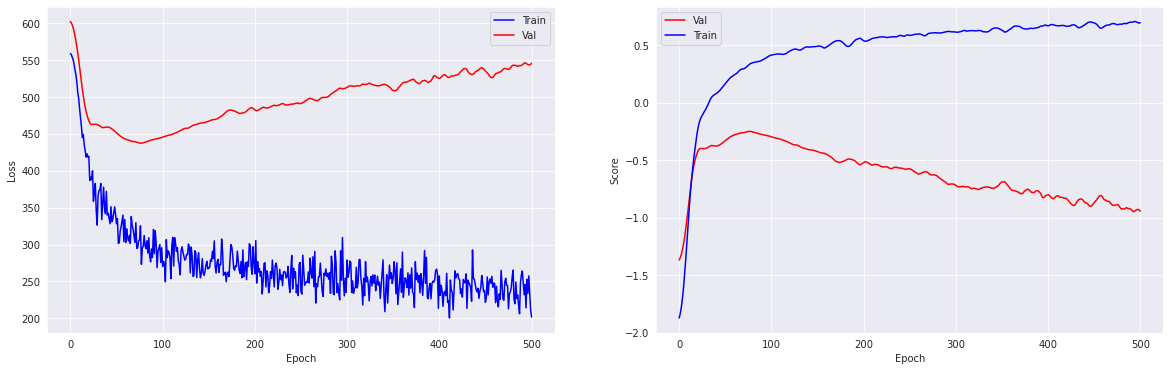

Test loss: 345.1583, test score: -0.3233


In [33]:
import datetime
# loss_fn = nn.HuberLoss(delta=200).to(device)

loss_fn = RMSELoss().to(device)
model = None


ds = torch.load('datasets/2021-01-08.dat')

train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=128)
train_batches = [batch for batch in train_loader]
train_nodes = [n for batch in train_batches for n in batch[0]]
train_targets = torch.cat([batch[1] for batch in train_batches])
    
if model is None:
    model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
else:
    model.set_observations(train_nodes, train_targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=500, plot=True)
test_loss, test_score = test(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [34]:
import datetime
# loss_fn = nn.HuberLoss(delta=50).to(device)
loss_fn = nn.MSELoss().to(device)
# model = None

for path in tqdm(glob.glob('datasets/*')[:]):
    try:
        day = path.split('/')[1].split('.')[0]
        day_num = datetime.datetime.strptime(day, '%Y-%m-%d').weekday()
        workday = day_num < 5
        
        if not (workday and datetime.datetime.strptime('2021-01-04', '%Y-%m-%d').weekday() < 5):
            continue
    except:
        continue

    try:
        ds = torch.load(path)
    except:
        print('ds not found')
        
    train_loader, val_loader, test_loader = make_dataloaders_from_dataset(ds, batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
        
    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, device)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

    # model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=40, plotting=False)
    # test_loss, test_score = test(model, test_loader, loss_fn, device)
    # print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

  0%|          | 0/31 [00:00<?, ?it/s]

2021-01-15, Test loss: 1505015.7500, test score: -0.0589
2021-01-04, Test loss: 105845.9141, test score: -0.0279
2020-12-28, Test loss: 113875.0625, test score: -0.3020
2021-01-06, Test loss: 100075.5469, test score: 0.0200
2021-01-13, Test loss: 109398.8125, test score: 0.0199
2021-01-20, Test loss: 91377.7422, test score: 0.0243
2021-01-18, Test loss: 67107.5312, test score: 0.0112
2021-01-12, Test loss: 100654.2109, test score: 0.0013
2020-12-29, Test loss: 119666.5312, test score: -0.2612
2021-01-07, Test loss: 107972.6250, test score: -0.0436
2020-12-30, Test loss: 110585.9141, test score: -0.0306
2021-01-19, Test loss: 107020.2109, test score: -0.1928
2021-01-05, Test loss: 105133.2109, test score: 0.0105
2020-12-31, Test loss: 75521.9141, test score: -0.0231
2021-01-22, Test loss: 97841.1484, test score: 0.0573
2021-01-21, Test loss: 119912.9766, test score: -0.2286
2021-01-08, Test loss: 119134.2969, test score: -0.3233
2021-01-01, Test loss: 78345.2812, test score: -2.6546
202